In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
import fcwt
from pydub import AudioSegment

# Load the audio file (modify the path as needed)
file_path = "Fiddle.wav"
sample_rate, audio_data = wav.read(file_path)
audio_data = audio_data[::4]
sample_rate = sample_rate/4
# Ensure the audio is mono
if len(audio_data.shape) > 1:
    audio_data = audio_data[:, 0]

# Define parameters
fs = 8000  # Sampling frequency (Hz)
duration = 20  # Duration of audio clip (s)
total_samples = fs * duration

c:\Users\24261951\Documents\Projects\.venv\Lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
C:\Users\24261951\AppData\Local\Temp\ipykernel_8852\3809810873.py:9: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, audio_data = wav.read(file_path)


In [3]:
def bandpass_filter(x, fs, f_low, f_high):
    return


In [4]:
def fcwt_custom_plotter(audio_data,sample_rate,filter = False):

    #make sure signal is a numpy float array
    signal = np.array(audio_data, dtype=np.float32)
    if filter:
        signal = np.float32(bandpass_filter(signal,200,1100,sample_rate))
    #signal = signal[::4]
    #sample_rate = sample_rate/4

    fn = 100
    f0 = 200
    f1 = 2500
    #initialize Morlet wavelet with wavelet parameter (sigma) 2.0
    morl = fcwt.Morlet(2.0)
    #initialize scales
    scales = fcwt.Scales(morl, fcwt.FCWT_LINFREQS, fs, f0, f1, fn)

    #initialize fcwt
    nthreads = 4
    use_optimization_plan = False
    use_normalization = True
    fcwt_obj = fcwt.FCWT(morl, nthreads, use_optimization_plan, use_normalization)

    #initialize output array
    output = np.zeros((fn,signal.size), dtype=np.complex64)

    #calculate cwt
    fcwt_obj.cwt(signal, scales, output)
    output = np.abs(output) ** 2

    #plot cwt
    plt.imshow(np.abs(output),aspect='auto')
    plt.show()
    return np.abs(output)

In [5]:
def fcwtplotter(audio_data,sample_rate,filter = True):
    #make sure signal is a numpy float array
    audio_data = np.array(audio_data, dtype=np.float32)
    audio_data -= np.mean(audio_data)
    # 2. Divide by the maximum absolute value to scale between -1 and 1
    max_val = np.max(np.abs(audio_data))
    if max_val > 0:
        signal = audio_data / max_val


    fn = 100
    f0 = 200
    f1 = 2500
    fcwt.plot(signal, sample_rate, f0=f0, f1=f1, fn=fn)


In [6]:
def cross_wavelet(signal1, signal2,frame_rate):
    highest = 1100
    freqs, coeffs1 = fcwt.cwt(signal1,frame_rate,200,highest,200,nthreads = 4)
    _, coeffs2 = fcwt.cwt(signal2,frame_rate,200,highest,200,nthreads = 4)

    S12 = coeffs1 * (coeffs2)
    return np.abs(S12),freqs,_

In [222]:
import cv2
import numpy as np

def reduce_resolution(image, new_shape):
    # Compute magnitude and phase
    magnitude = np.abs(image)
    phase = np.angle(image)
    
    # Resize using OpenCV
    magnitude_resized = cv2.resize(magnitude, new_shape, interpolation=cv2.INTER_AREA)  # Best for downscaling
    phase_resized = cv2.resize(phase, new_shape, interpolation=cv2.INTER_LINEAR)  # Phase needs smooth interpolation
    
    # Reconstruct the complex image
    resized_image = magnitude_resized * np.exp(1j * phase_resized)
    
    return resized_image

def increase_contrast_complex(image, alpha=2.0, beta=0):
    """
    Increase the contrast of a complex image array.
    
    Parameters:
    - image: Complex numpy array (with real and imaginary parts)
    - alpha: Contrast control (1.0 means no change, >1.0 increases contrast)
    - beta: Brightness control (0 means no change)
    
    Returns:
    - contrasted_image: The complex image with enhanced contrast
    """
    # Separate magnitude and phase
    magnitude = np.abs(image)
    phase = np.angle(image)
    
    # Apply contrast enhancement to magnitude
    magnitude_contrasted = np.clip(alpha * magnitude + beta, 0, 1)
    
    # Reconstruct the complex image with the enhanced magnitude
    contrasted_image = magnitude_contrasted * np.exp(1j * phase)
    
    return contrasted_image

In [341]:
import numpy as np
from pycwt import wct
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, convolve1d,zoom
import scipy.io.wavfile as wav
from PIL import Image, ImageEnhance
# Compute the wavelet coherence
def gamma_correction_complex(image, gamma=.35):
    # Compute magnitude and phase
    image = reduce_resolution(image, (400,200))
    
    magnitude = np.abs(image)
    phase = np.angle(image)
    magnitude_max = np.max(magnitude)
    if magnitude_max > 0:
        magnitude = magnitude / magnitude_max  # Normalize to [0,1]
    magnitude = np.clip(magnitude*4, .1, 1)
    # Apply gamma correction to the magnitude
    magnitude_corrected = np.power(magnitude, gamma)
    blur_strength = 2
    blur_kernel = np.ones(blur_strength) / blur_strength  # 1D blur kernel
    magnitude_corrected = convolve1d(magnitude_corrected, blur_kernel, axis=1, mode='reflect')

    # Reconstruct the complex image
    corrected_image = magnitude_corrected * np.exp(1j * phase)
    return corrected_image


def wavelet_coherence(signal1, signal2,frame_rate):
    highest = 5000
    lowest = 200
    nfreqs = 300
    freqs, coeffs1 = fcwt.cwt(signal1,frame_rate,lowest,highest,nfreqs,nthreads = 4,scaling='log')
    
    _, coeffs2 = fcwt.cwt(signal2,frame_rate,lowest,highest,nfreqs,nthreads = 4,scaling='log')
    coeffs1 = gamma_correction_complex(coeffs1)
    coeffs2 = gamma_correction_complex(coeffs2)
    
    # Compute coherence
    S1 = np.abs(coeffs1) ** 2
    S2 = np.abs(coeffs2) ** 2
    S12 = coeffs1 * np.conj(coeffs2)
    
    # Smooth spectra and cross-spectrum
    def smooth(data, sigma=(2,2), mode='nearest'):
        return data
        #ensure only horizontal smoothing
        return gaussian_filter(data, sigma=sigma, mode=mode)

    S1_smoothed = smooth(S1)
    S2_smoothed = smooth(S2)
    S12_smoothed = smooth(np.abs(S12) ** 2)

    # Coherence calculation
    #coherence = S12_smoothed / (((S1_smoothed) **2) * ((S2_smoothed)**2))
    coherence = S12_smoothed / (np.sqrt(S1_smoothed) * np.sqrt(S2_smoothed))

    return coherence, freqs, [coeffs1,coeffs2]


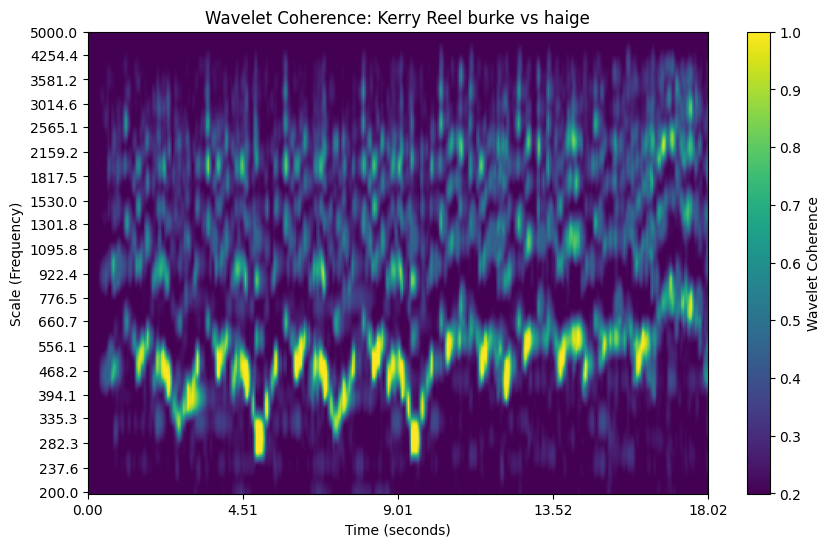

In [343]:

def coherence_plot(data1,data2,frame_rate):
    audio_data1 = np.array(data1, dtype=np.float32)
    audio_data1 -= np.mean(audio_data1)
    # 2. Divide by the maximum absolute value to scale between -1 and 1
    max1 = np.max(np.abs(audio_data1))
    if max1 > 0:
        data1 = audio_data1 / max1
    audio_data2 = np.array(data2, dtype=np.float32)
    audio_data2 -= np.mean(audio_data2)
    # 2. Divide by the maximum absolute value to scale between -1 and 1
    max2 = np.max(np.abs(audio_data2))
    if max2 > 0:
        data2 = audio_data2 / max2

    coherence, freqs, coeffs = wavelet_coherence(data1, data2, frame_rate)
    extent=[0, len(data1)/frame_rate, len(freqs),0]

    y_values = np.logspace(np.log10(freqs[0]), np.log10(freqs[-1]), len(freqs))
    subsampled_indices = np.linspace(0, len(y_values) - 1, 20, dtype=int)
    subsampled_y_values = y_values[subsampled_indices]
    plt.figure(figsize=(10, 6))
    plt.imshow(coherence, aspect='auto', extent=extent)
    plt.yticks(ticks=subsampled_indices, labels=[f"{y:.1f}" for y in subsampled_y_values])
    plt.xticks(np.linspace(0, len(data1)/frame_rate, 5))
    plt.colorbar(label='Wavelet Coherence')
    plt.ylabel('Scale (Frequency)')
    plt.xlabel('Time (seconds)')
    plt.title('Wavelet Coherence: Kerry Reel burke vs haige')
    plt.show()


frame_rate = 8000
data1 = AudioSegment.from_wav('kerry_reel_burke.wav').set_frame_rate(frame_rate).split_to_mono()[0]
data2 = AudioSegment.from_wav('kerry_reel_haige.wav').set_frame_rate(frame_rate).split_to_mono()[0]
data1 = np.frombuffer(data1.raw_data,np.int16)
data2 = np.frombuffer(data2.raw_data,np.int16)[:len(data1)]
#frame_rate = data1.frame_rate
coherence_plot(data1,data2,frame_rate)


In [1]:
plt.figure(figsize=(10, 6))
frame_rate = 8000
data1 = AudioSegment.from_wav('kerry_reel_burke.wav').set_frame_rate(frame_rate)
data2 = AudioSegment.from_wav('kerry_reel_haige.wav').set_frame_rate(frame_rate)
data1 = np.frombuffer(data1.raw_data,np.int16)
data2 = np.frombuffer(data2.raw_data,np.int16)
coherence_plot(data1,data2,frame_rate)

NameError: name 'plt' is not defined

In [ ]:
from scipy.signal import butter, filtfilt

# Bandpass filter function
def bandpass_filter(signal, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal